<a href="https://colab.research.google.com/github/gguliants/MIT-SureStart/blob/main/GG_Day_14_Upsampling_And_Autoencoders_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

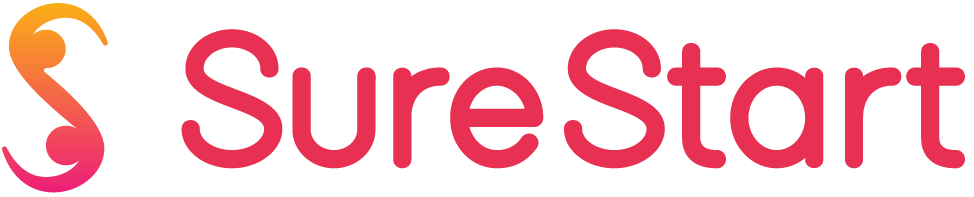

#Day 14 Objectives:
* To familiarize you with upsampling and downsampling.
* To introduce you to Autoencoders.


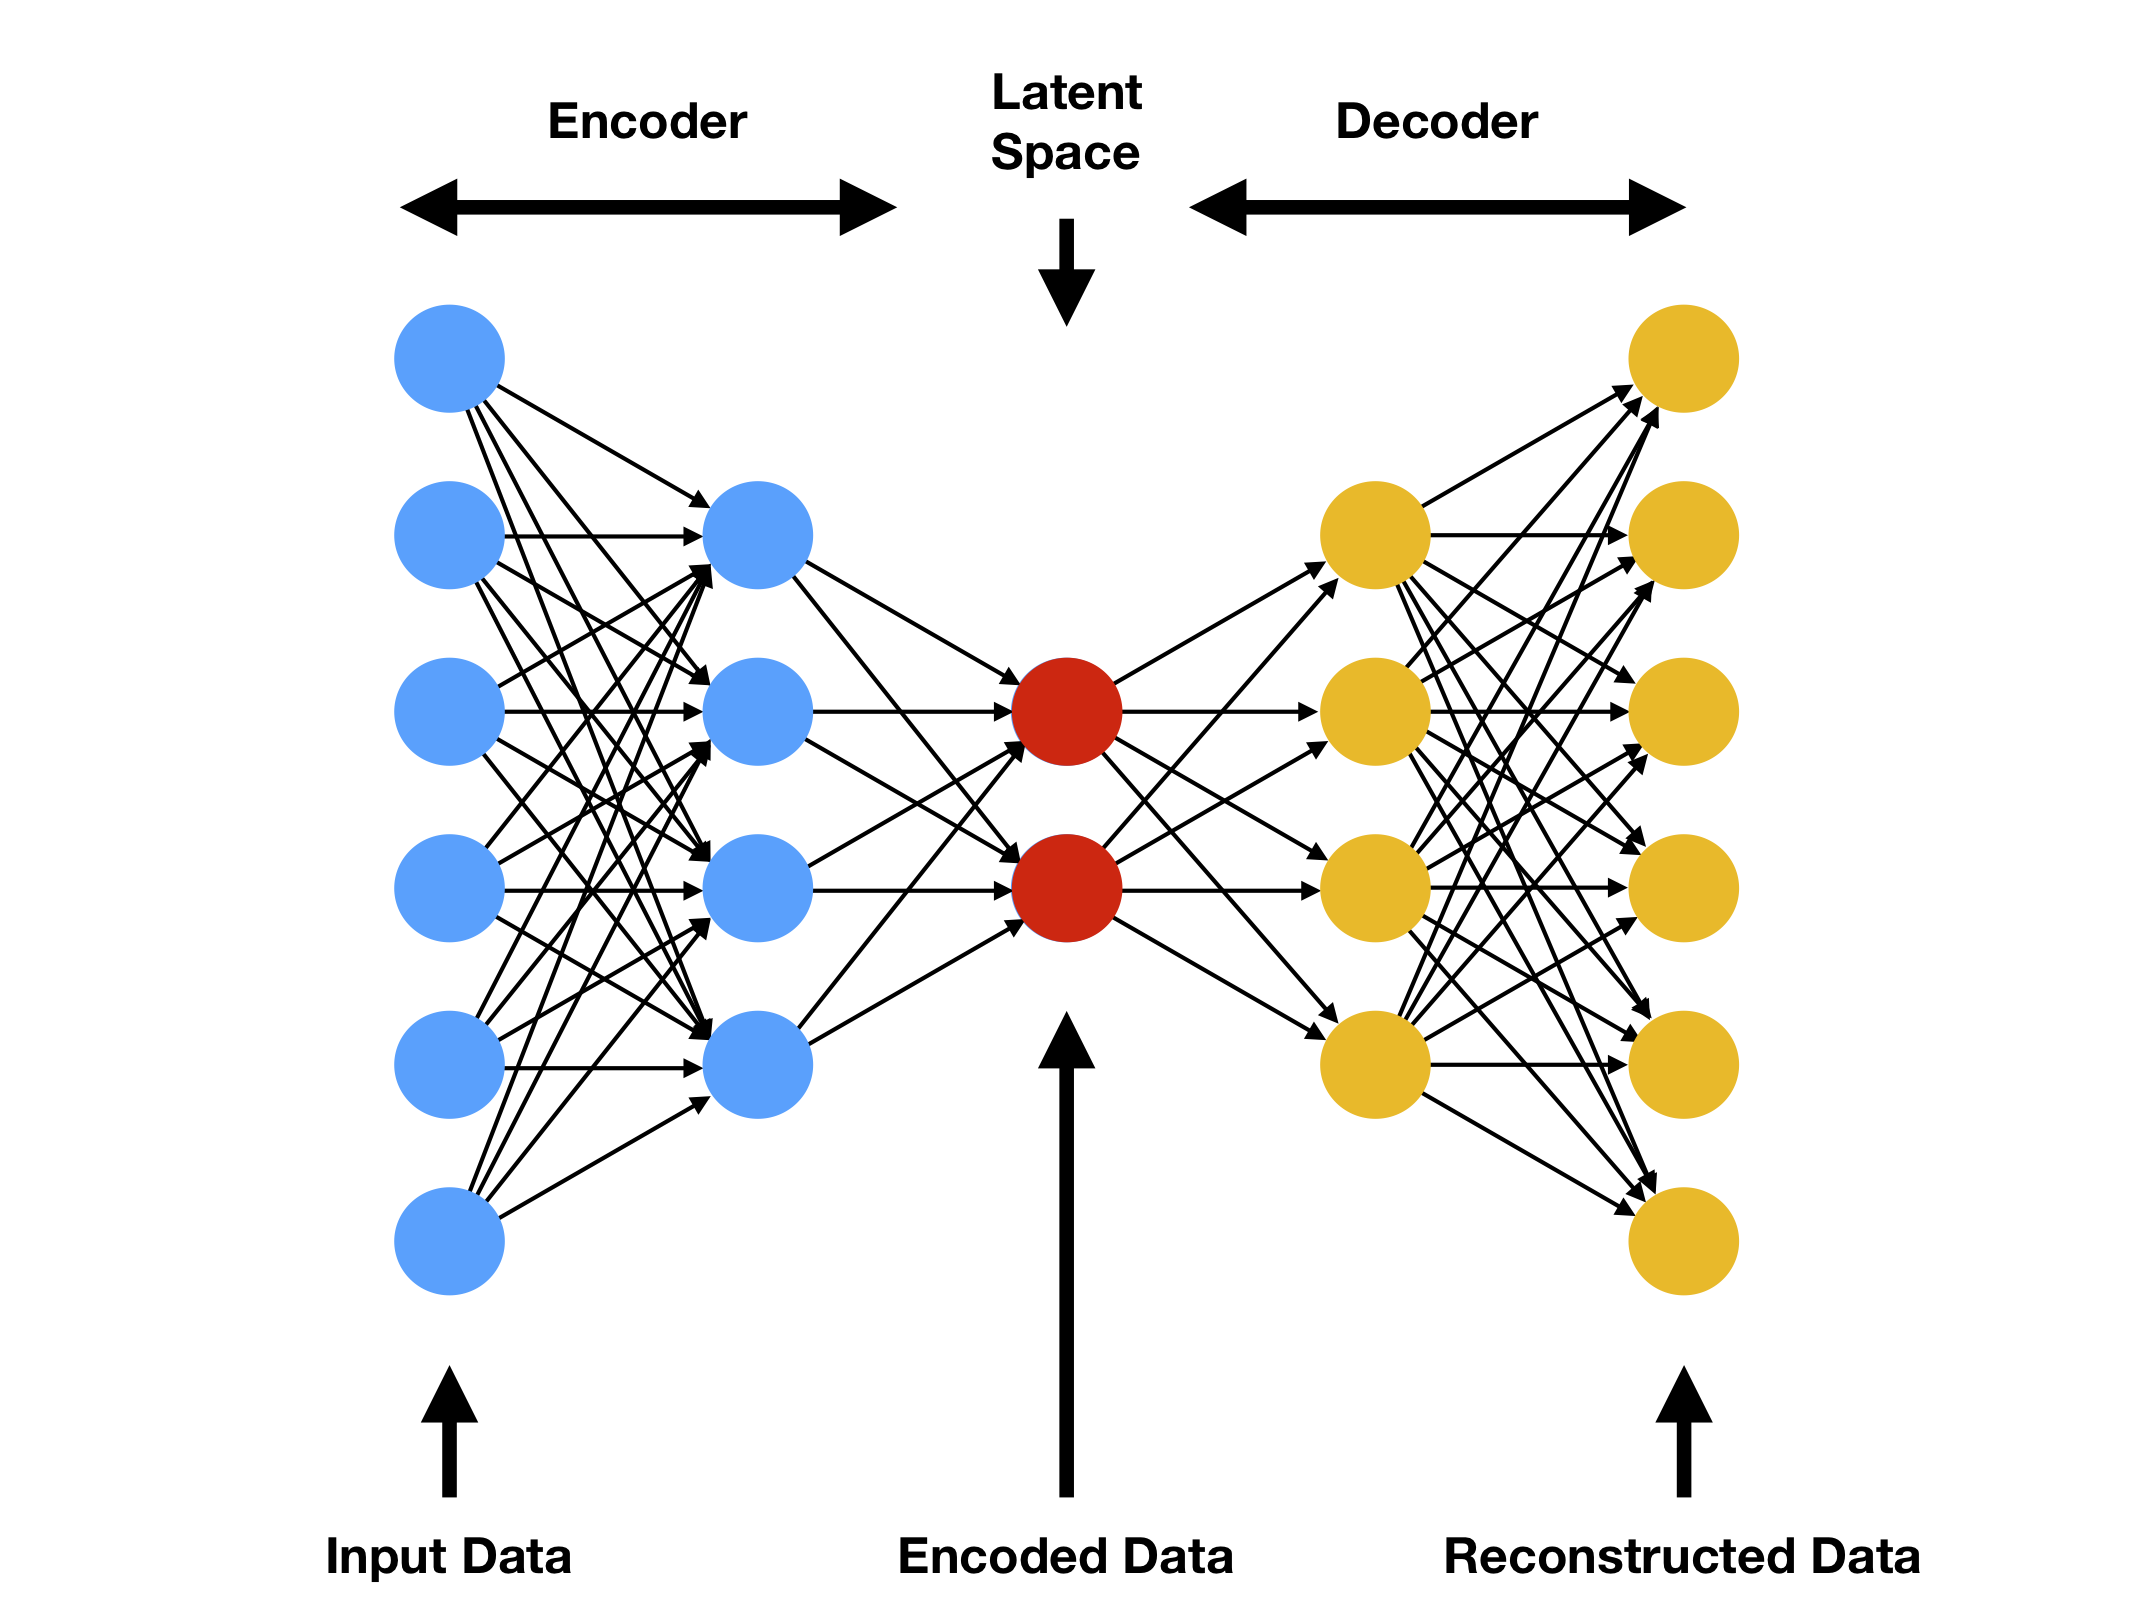

# Autoencoders

Autoencoders are a class of unsupervised networks that consist of two major components: **Encoders** and **Decoders**.

An unsupervised network is a neural network that learns patterns from data without any training labels (without being told what those patterns should be).

In contrast, there are supervised networks where the network is trained to return specific outputs when given specific inputs.

The *Encoder* generally uses a series of dense and/or convolutional layers to encode an image into a fixed length vector which represents the image in a compact form. While the *Decoder* uses dense and/or convolutional layers to convert the latent representation vector back into that same image or another modified image.

The figure above shows an example of a simple autoencoder. In this autoencoder, you can see that the input is compressed into a latent space (the compressed vector is called *latent representation vector*) and then decompressed (reconstructed) into the image of same size as input image.

To generate an image, a random input vector is given to the *decoder* network. The decoder attempts to recreate the input from the compressed version provided.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

## Upsampling and Downsampling

Let's introduce some more terminology before we can dive into autoencoders.

**Upsampling**: can be synonymous with expansion, or it can describe an entire process of expansion and filtering (interpolation).

**Downsampling**: can be synonymous with compression, or it can describe an entire process of reduction (filtering).

Source: [Wikipedia](https://en.wikipedia.org/wiki/Upsampling)

## Question 1

Now that you know what encoder and decoder are, tell us which one performs upsampling and which one performs downsampling.

***ANSWER:***
**The encoder performs downsampling, and the decoder performs upsampling.**

#Data Loading

We are using the MNIST number dataset

11501568/11490434 [==============================] - 0s 0us/step


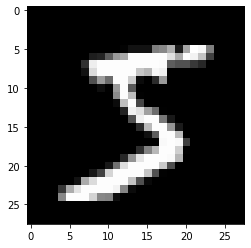

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

# Deciding the Latent Size
**Latent representation vector** is the vector holding the information after compression. The size of that vector is called *latent size*. This value is a crucial hyperparameter. If this value is too small, there won't be enough data for reconstruction and if the value is too large, overfitting can occur.

The latent size can also be considered as the dimensions we model the middle of an autoencoder as, where the encoder and decoder are connected.

In [3]:
LATENT_SIZE = 32

Provided that the encoders have sufficient capability to learn some arbitrary function, it can map the data to a smaller sized representation. For deep autoencoders, we must also be aware of the capacity of our encoder and decoder models. Even if the "bottleneck layer" (where the latent representation vector is generated) is only one hidden node, it's still possible for our model to memorize the training data. 

## Question 2

Is there a lower and upper bound to the latent size with respect to the dimensions of the data?

***Answer:***
**The lower bound should be near the number of classes, while the upper bound should be the flattened size of the input. Latent size cannot be the size of the input directly because that leads to memorization of data rather than learning.**

#Creating the Encoder
The encoder downscales and compresses the data available to the latent size where the intermediate representation of a model is available.

Here the encoder is just a feed forward neural network which decreases its dense layer output dimensions as it goes forward.

In [4]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28)),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(LATENT_SIZE),
    tf.keras.layers.LeakyReLU()
])

The encoder consists of a series of dense layers with dropout and LeakyReLU layers. The dense layers allow for the compression of the 28x28 input tensor down to the latent vector of size 32. The dropout layers help prevent overfitting. LeakyReLU, being the activation layer, introduces non-linearity into the mix. `Dense(LATENT_SIZE)` creates the final vector of size 32.


## Question 3
Can the encoder be used as a classifier?

**Yes, the autoencoder can be used as a classifier. However, this would require the last layer to be sigmoid or softmax (rather than ReLu) because it would need to align with a classification task.**

#Creating the Decoder
Decoder is also a feedforward network like the encoder and has a similar structure to the encoder. This network is responsible for reconstructing the input back to the original dimensions from the representation vector (also called compressed vector or latent vector).

First, the input goes through the encoder where it is compressed, then the decoder decompresses the original input from the representation vector. The main objective of the autoencoder is **to get an output identical to the input**.

Note that the decoder architecture is the mirror image of the encoder. This is not a requirement but it’s typically the case. The only requirement is the sizes of the input and output vectors must be the same.

In [5]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape = (LATENT_SIZE,)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(784),
    tf.keras.layers.Activation("sigmoid"),
    tf.keras.layers.Reshape((28, 28))
])


The decoder is essentially the same as the encoder but in reverse. The final activation layer is sigmoid, however. The sigmoid activation function output values in the range [0, 1] which fits perfectly with our scaled image data.

##Question 4

Can the decoder be used as a generator (synthesizer) of some data?

**Yes.**

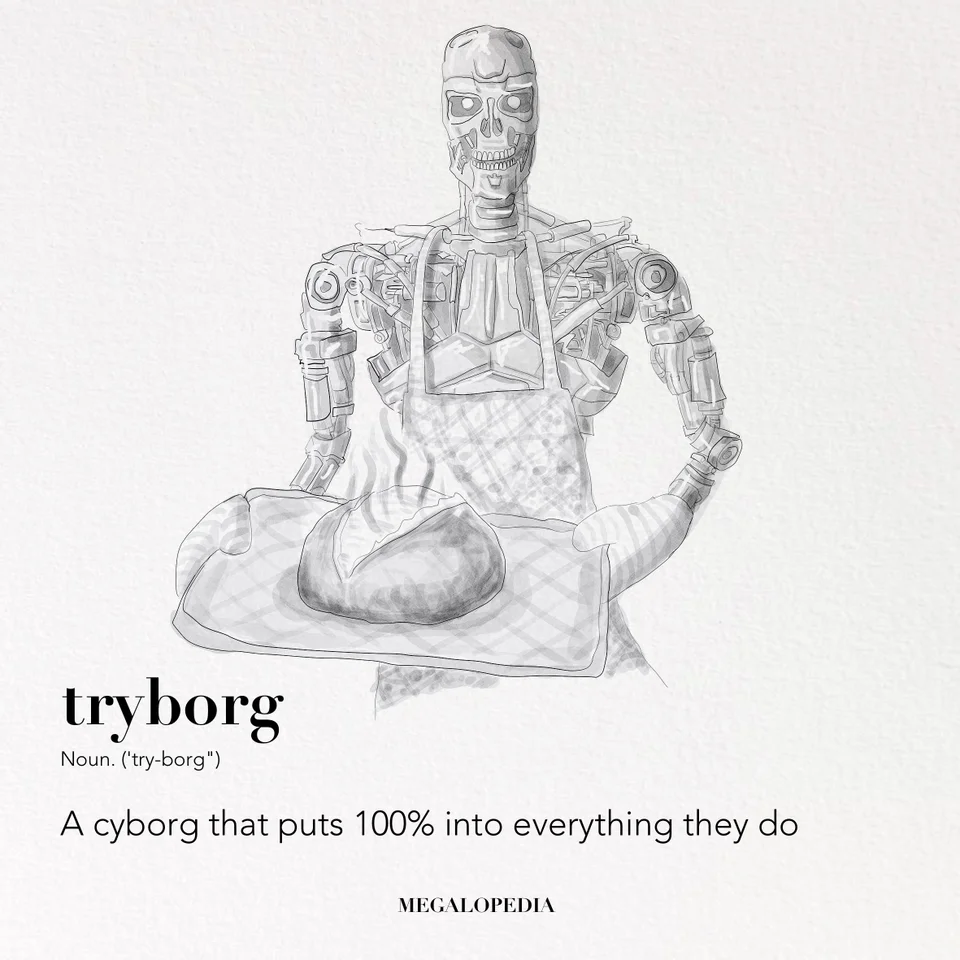

#Creating the Full Model
"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1. Autoencoders are **data-specific**, which means that they will only be able to 
compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2. Autoencoders are **lossy**, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3. Autoencoders are **learned automatically** from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). 

The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using stochastic gradient descent.

In [6]:
img = tf.keras.Input(shape = (28, 28))

This will create a placeholder tensor which we can feed into each network to get the output of the whole model.

In [7]:
latent_vector = encoder(img)
output = decoder(latent_vector)

The best part about the Keras Functional API is how readable it is. The Keras Functional API allows you to call models directly onto tensors and get the output from that tensor. By calling the encoder model onto the `img` tensor, we get the `latent_vector`. The same can be done with the decoder model onto the `latent_vector` which gives us the output.


In [8]:
model = tf.keras.Model(inputs = img, outputs = output)
model.compile("nadam", loss = "binary_crossentropy")

To create the model itself, you use the `tf.keras.Model` class and define what the inputs and outputs of the model are.
To train a model, you must compile it. To compile a model, you have to choose an optimizer and a loss function. For the optimizer, we chose Nadam, which is Nesterov Accelerated Gradient applied to Adaptive Moment Estimation. It is a modified Adam optimizer. 

For the loss, we chose binary cross-entropy. Binary Cross-Entropy is very commonly used with autoencoders. Usually, however, binary cross-entropy is used with binary classifiers. Additionally, binary cross-entropy can only be used between output values in the range [0, 1].

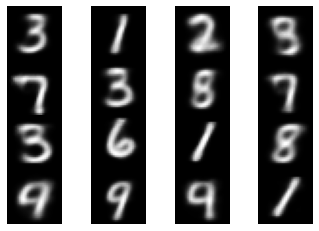

----------- EPOCH 59 -----------
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1911


In [9]:
EPOCHS = 60
#Training the Model
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))
    
    display.clear_output() # If you imported display from IPython
    
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")
    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)


First, we create plots with 4 rows and 4 columns of subplots and choose 16 random testing data images to check how well the network performs.
Next, we clear the screen (only works on IPython, Jupyter, and Colab notebooks) and plot the predictions by the model on the random testing images.

Finally, we train the model. To train the model we simply call `model.fit` on the training image data. Remember how the autoencoder’s goal is to take the input data, compress it, decompress it, and then output a copy of the input data? This means that the input and the target output are both the training image data.

As you can see, these generated images are pretty good. The biggest problem with the images, however, is with the blurriness. Many of these problems can be fixed with other types of generative networks or even other types of autoencoders.

## Question 5

Train an autoencoder with latent size between 10 to 15.
Learn what hyperparameters it requires to create a '0' as the output image.

### Answer 5

You have seen the process to create and train a Decoder and Encoder in order to form an Autoencoder

Replicate the process here

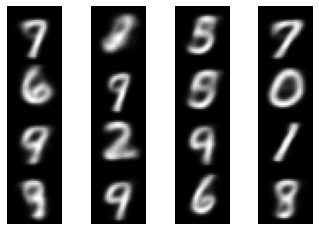

----------- EPOCH 9 -----------
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1951


In [10]:
LATENT_SIZE = 12
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28, 28)),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(LATENT_SIZE),
    tf.keras.layers.LeakyReLU()
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape = (LATENT_SIZE,)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(784),
    tf.keras.layers.Activation("sigmoid"),
    tf.keras.layers.Reshape((28, 28))
])

img = tf.keras.Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)

model = tf.keras.Model(inputs = img, outputs = output)
model.compile("nadam", loss = "binary_crossentropy")

EPOCHS = 10 #decided to do 10 epochs for time efficiency
#Training the Model
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))
    
    display.clear_output() # If you imported display from IPython
    
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")
    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)


#Convolutional autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder consists of a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial downsampling), while the decoder consists of a stack of `Conv2D` and `UpSampling2D` layers.

We have already built an autoencoder -- separately as an encoder and decoder before. Let's merge it all together and build another autoencoder now.

In [11]:
autoencoder = tf.keras.models.Sequential([tf.keras.Input(shape=(28, 28, 1)),
 tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.UpSampling2D((2, 2)),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.UpSampling2D((2, 2)),
 tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
 tf.keras.layers.UpSampling2D((2, 2)),
 tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [12]:
autoencoder.fit(x_train, x_train,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
                )

469/469 [==============================] - 77s 163ms/step - loss: 0.2084 - val_loss: 0.1447



The model converges to a loss which is significantly better than our previous models (this is in large part due to the higher capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:



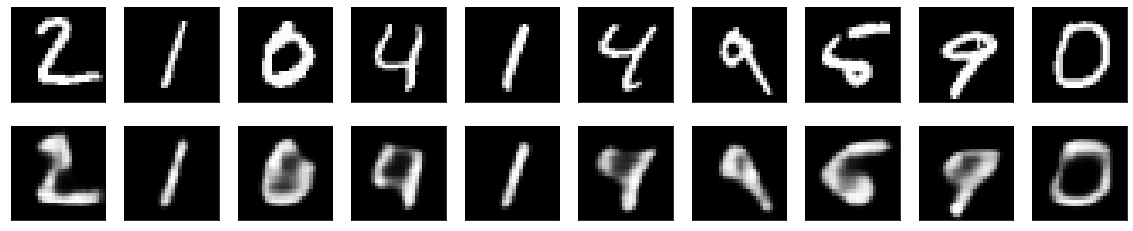

In [13]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Let's look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to display them as grayscale images.



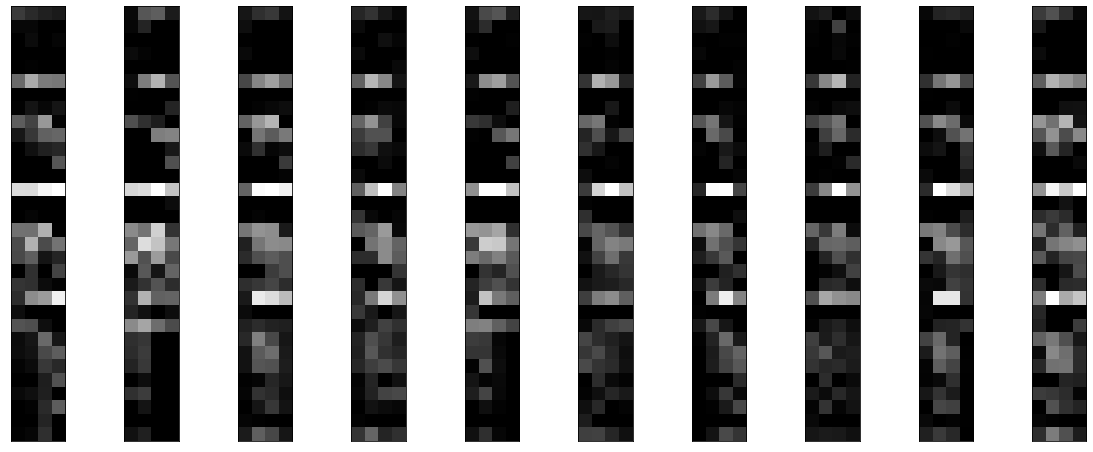

In [14]:
encoder = tf.keras.models.Sequential([tf.keras.Input(shape=(28, 28, 1)),
 tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same')])

encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Question 6

Implement an encoder and a decoder as seperate models for the ConvAE we just worked on. Make sure the entire pipieline with inputs getting fed to the encoder and the decoder outputting the reconstructed inputs still works same. 

### Answer 6

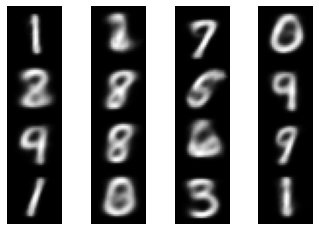

----------- EPOCH 3 -----------
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1938


In [15]:
encoder = tf.keras.models.Sequential([tf.keras.Input(shape=(28, 28, 1)),
 tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.MaxPooling2D((2, 2), padding='same')])

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

decoder = tf.keras.models.Sequential([tf.keras.Input(shape=(28, 28, 1)),
 tf.keras.layers.UpSampling2D((2, 2)),
 tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
 tf.keras.layers.UpSampling2D((2, 2)),
 tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
 tf.keras.layers.UpSampling2D((2, 2)),
 tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')])


EPOCHS = 4
#Training the Model
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))
    
    display.clear_output() # If you imported display from IPython
    
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")
    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)


# Bonus Section : Variational autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function which maps input to a reprensetation, you are learning the parameters of a the arbitrary function which is modeling those representation. If you sample points from this function, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples $x$ into two parameters in a latent space, which we will note `z_mean` and `z_log_sigma`. Then, we randomly sample similar points $z$ from the latent normal distribution that is assumed to generate the data, via `z = z_mean + exp(z_log_sigma) * epsilon`, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick. In our example, you approximate  using the decoder parameters and another parameter $ϵ$ follows:
$z = \mu + \sigma \bigodot \epsilon $

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\epsilon$, $\sigma$ and $\mu$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Let's define an encoder.

For the encoder network, use two convolutional layers followed by a dense layer. 

In [18]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 32)   320         ['input_7[0][0]']                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_16[0][0]']              
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_17[0][0]']              
                                                                                            

Let's define a decoder.

In the decoder network, mirror the encoder architecture by using a dense (also known as fully connected) layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts).

In [19]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_21 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

 Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

# Define the VAE
There are two generative models facing neck to neck in the data generation business right now: Generative Adversarial Nets (GAN) and Variational Autoencoder (VAE). These two models have different take on how the models are trained. GAN is rooted in game theory, its objective is to find the Nash Equilibrium between discriminator net and generator net. On the other hand, VAE is rooted in bayesian inference, i.e. it wants to model the underlying probability distribution of data so that it could sample new data from that distribution.

Suppose we want to generate a data. Good way to do it is first to decide what kind of data we want to generate, then actually generate the data. For example, say, we want to generate an animal. First, we imagine the animal: it must have four legs, and it must be able to swim. Having those criteria, we could then actually generate the animal by sampling from the animal kingdom. Lo and behold, we get Platypus!

From the story above, our imagination is analogous to latent variable. It is often useful to decide the latent variable first in generative models, as latent variable could describe our data. Without latent variable, it is as if we just generate data blindly. And this is the difference between GAN and VAE: VAE uses latent variable, hence it’s an expressive model.

Here we have defined a custom training step and the loss calculation ourselves for the same reason.

Can you figure it out why we did it this way?

In [20]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


##Question 7

Write your observations on how ConvAE and VAE differs (in their structure and the outputs they produced).

**ConvAE functions more as a plot, while VAE returns different loss values. VAE functions call on methods to measure loss.**

What we've done so far allows us to instantiate 3 models:

* an end-to-end autoencoder mapping inputs to reconstructions
* an encoder mapping inputs to the latent space
* a decoder (generator) that can take points on the latent space and will output the corresponding reconstructed samples.

We train the end-to-end model with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [21]:
(x_train, y_test), (x_test, y_test ) = keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 101s 183ms/step - loss: 256.8277 - reconstruction_loss: 211.1318 - kl_loss: 2.3092
Epoch 2/30
547/547 [==============================] - 99s 181ms/step - loss: 191.1883 - reconstruction_loss: 185.5884 - kl_loss: 3.1139
Epoch 3/30
547/547 [==============================] - 101s 184ms/step - loss: 172.2843 - reconstruction_loss: 164.0858 - kl_loss: 5.3486
Epoch 4/30
547/547 [==============================] - 101s 185ms/step - loss: 164.2643 - reconstruction_loss: 157.6445 - kl_loss: 5.7531
Epoch 5/30
547/547 [==============================] - 101s 185ms/step - loss: 160.8039 - reconstruction_loss: 154.4321 - kl_loss: 5.9618
Epoch 6/30
547/547 [==============================] - 100s 183ms/step - loss: 158.9460 - reconstruction_loss: 152.5692 - kl_loss: 6.0950
Epoch 7/30
547/547 [==============================] - 101s 185ms/step - loss: 157.4715 - reconstruction_loss: 151.1483 - kl_loss: 6.1776
Epoch 8/30
547/547 [======================

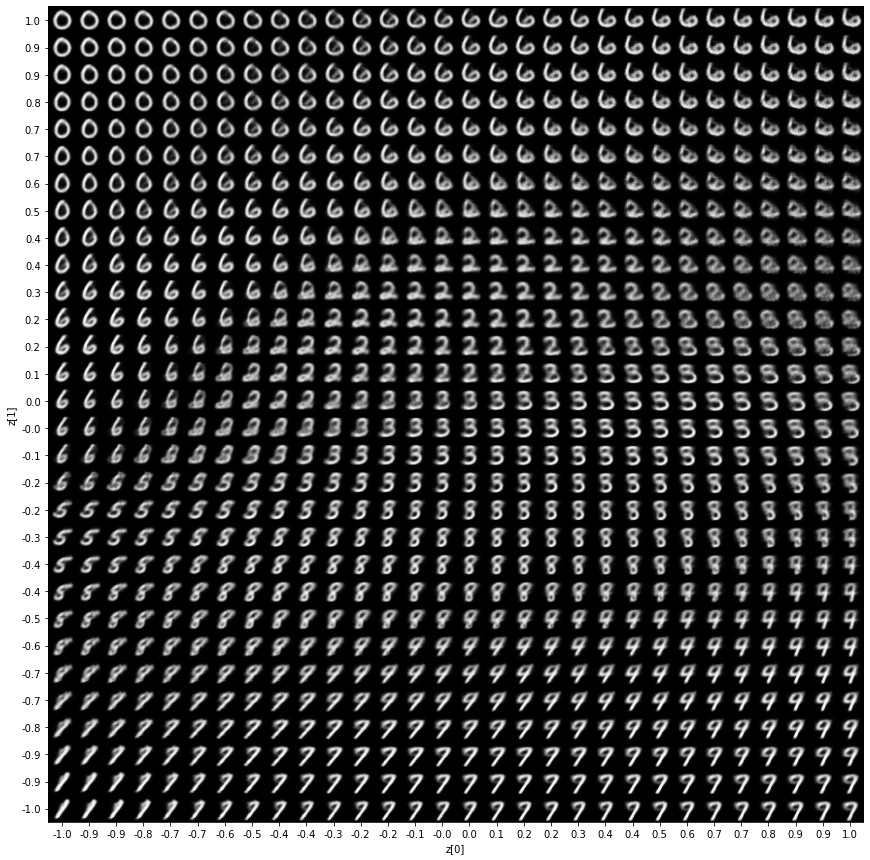

In [23]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


#Display how the latent space clusters different digit classes
Because our latent space is two-dimensional, there are a few cool visualizations that can be done at this point. One is to look at the neighborhoods of different classes on the latent 2D plane:



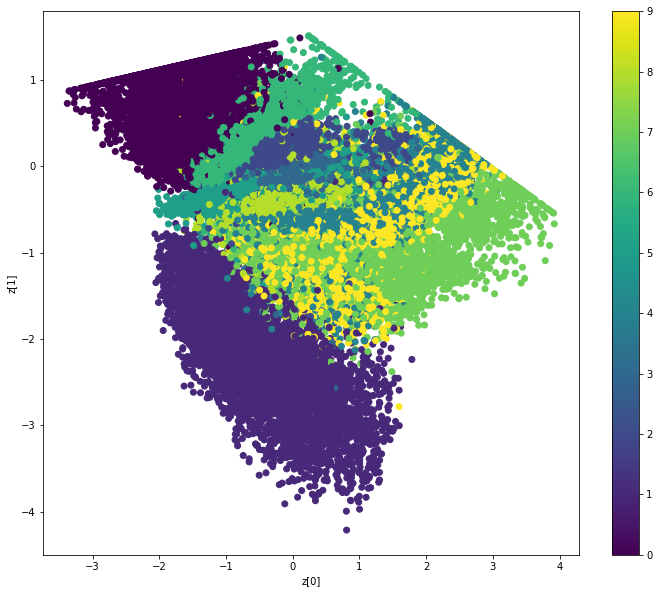

In [24]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,cmap = 'viridis')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

Because the VAE is a generative model, we can also use it to generate new digits! Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

# **Upload this Day 14 Colab Notebook to your Github repository under "Day 14" folder. Also add your *Reflection* on today's learning in README.md**

Sources:

https://blog.keras.io/building-autoencoders-in-keras.html

https://www.tensorflow.org/tutorials/generative/cvae